# SNS Sentiment Analysis LR

Analyze social media texts and measure potential inflammatory / offensive language with a logistic regression.

In [1]:
import ast
import pandas as pd
import data_util as du
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt

# Load data

In [2]:
# Load dataset
train = pd.read_csv("./datasets/processed/train.csv")
X_train = train[train.columns[0]].apply(ast.literal_eval)
y_train = train[train.columns[1]].astype(int)
print(X_train.shape, y_train.shape)

test = pd.read_csv("./datasets/processed/test.csv")
X_test = test[test.columns[0]].apply(ast.literal_eval)
y_test = test[test.columns[1]].astype(int)
print(X_test.shape, y_test.shape)

# Load vocabulary
vocabulary = ast.literal_eval(open("./datasets/processed/vocabulary.txt", "r").read())
print("Vocabulary size:", len(vocabulary))

(8000,) (8000,)
(2000,) (2000,)
Vocabulary size: 11560


In [3]:
train_text = [" ".join(s) for s in X_train]
test_text = [" ".join(s) for s in X_test]
print("Lengths of train and test:", len(train_text), len(test_text))

Lengths of train and test: 8000 2000


# Vectorize data

In multinomial vectorization, we use it to calculate probabilities based on frequency of words from the vocabulary than whether the word has appeared at least once.

In [4]:
m_vectorizer = CountVectorizer(input='content', stop_words='english', binary=False, vocabulary=vocabulary, tokenizer=None, preprocessor=None)
X_train_m = m_vectorizer.fit_transform(train_text)
X_test_m = m_vectorizer.transform(test_text)
print("Vocabulary size:", len(m_vectorizer.get_feature_names_out()))

Vocabulary size: 11560


# Build logistic regression model and train

In [25]:
lr_model = LogisticRegression(C=0.1, penalty='l1', solver='liblinear', max_iter=1000, multi_class='auto')

In [6]:
lr_model.fit(X_train_m, y_train)

LogisticRegression(C=0.1, max_iter=1000, penalty='l1', solver='liblinear')

In [13]:
lr_model_2 = LogisticRegression(C=1, penalty='l2', multi_class='ovr')

In [14]:
lr_model_2.fit(X_train_m, y_train)

LogisticRegression(C=1, multi_class='ovr')

In [7]:
# Save as pickle
with open("./models/sns_multinomial_lr.pkl", "wb") as f:
    pickle.dump(lr_model, f)

In [86]:
# Save as pickle
with open("./models/sns_multinomial_lr_2.pkl", "wb") as f:
    pickle.dump(lr_model_2, f)

In [6]:
# Load from pickle
lr_model = pickle.load(open("./models/sns_multinomial_lr.pkl", "rb"))
lr_model_2 = pickle.load(open("./models/sns_multinomial_lr_2.pkl", "rb"))

# Make predictions

In [7]:
lr_pred_probs = lr_model.predict_proba(X_test_m)
lr_preds = lr_model.predict(X_test_m)

In [27]:
_ = du.get_prfa(y_test, lr_preds, verbose=True)

Precision: 0.6677713338856669
Recall: 0.8116817724068479
F1 Score: 0.7327272727272727
Accuracy: 0.706


In [8]:
lr_model_2_preds = lr_model_2.predict(X_test_m)
_ = du.get_prfa(y_test, lr_model_2_preds, verbose=True)

Precision: 0.7113309352517986
Recall: 0.796576032225579
F1 Score: 0.7515439429928742
Accuracy: 0.7385


In [9]:
def predict_inflammatory_level(text):
    vec_text = m_vectorizer.transform([text])
    return float(lr_model.predict_proba(vec_text)[:, 1])

In [10]:
example = predict_inflammatory_level("This is regular text")
example_pred = du.probs_to_preds([[example]])
print("Likeliness of inflammatory language:", example)
print("Prediction:", example_pred, "(not inflammatory)")

Likeliness of inflammatory language: 0.40115793840859276
Prediction: [0] (not inflammatory)


In [11]:
def remove_duplicate_labels(ax_graph):
    handles, labels = ax_graph.get_legend_handles_labels()
    unique = [(h, l) for j, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:j]]
    ax_graph.legend(*zip(*unique))

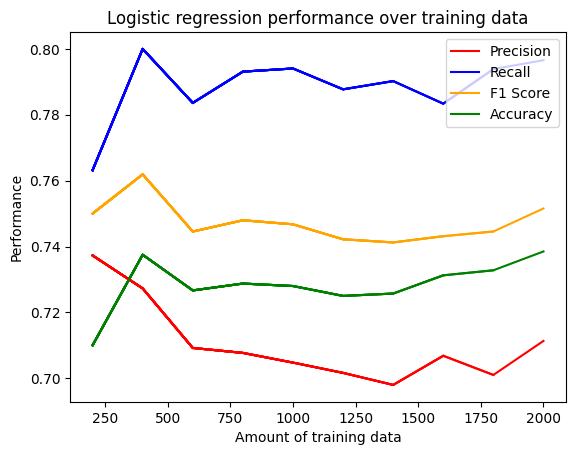

In [16]:
x_values = []
train_sizes = range(10, 101, 10)
metrics_dict = dict({
    'precision': [],
    'recall': [],
    'f1': [],
    'accuracy': []
})

fig, ax = plt.subplots()

for i in train_sizes:
    # |X| * percent of train size
    subset = int(round(len(lr_model_2_preds) * (float(i) / float(100))))
    x_values.append(subset)

    pred_subset = int(round(len(y_test) * (float(i) / float(100))))
    classification = lr_model_2_preds[:pred_subset]
    (precision, recall, f1, accuracy) = du.get_prfa(y_test[:pred_subset], classification, verbose=False)

    metrics_dict['precision'].append(precision)
    metrics_dict['recall'].append(recall)
    metrics_dict['f1'].append(f1)
    metrics_dict['accuracy'].append(accuracy)

    ax.plot(x_values, metrics_dict['precision'], label='Precision', color='red')
    ax.plot(x_values, metrics_dict['recall'], label='Recall', color='blue')
    ax.plot(x_values, metrics_dict['f1'], label='F1 Score', color='orange')
    ax.plot(x_values, metrics_dict['accuracy'], label='Accuracy', color='green')

plt.savefig('./graphs/lr_history_2.png')
plt.xlabel("Amount of training data")
plt.ylabel("Performance")
plt.title("Logistic regression performance over training data")
remove_duplicate_labels(ax)
plt.show()